## 1. Elección del dataset
Hemos elegido como dataset: https://www.kaggle.com/datasets/sakshigoyal7/credit-card-customers. Que, además de permitirnos aplicar lo aprendido en la asignatura, también nos diese unos resultados con algo de significado. Así, tendríamos la comparación de qué tan bueno es el modelo, pudiendo sacar una conclusión lógica de una predicción "razonable". 
Este dataset se centra principalmente en la predicción, dentro de un banco, de clientes que cancelan sus servicios (tarjetas de crédito en concreto) para así, retenerles con incentivos o ventajas antes de que dejen de contar con dichos servicios. 

La desventaja de este dataset es que cuenta con solo el 16,07% de clientes que anularon sus tarjetas. Sin embargo, aunque para el problema real pueda ser insuficiente, nosotros consideramos que, gracias a la cantidad de datos, nos puede servir bastante bien para entender las relaciones entre distintas variables y, con ello, sacar una predicción buena. Además, nosotros buscaremos predecir el rango de ingresos en función de las demás variables.

In [166]:
# Importación de librerías y lectura del dataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

url = "https://raw.githubusercontent.com/pabloruizburgos/AA/refs/heads/main/data/BankChurners.csv"
datos = pd.read_csv(url)
datos

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,0.000093,0.999910
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,0.000057,0.999940
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,0.000021,0.999980
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,...,3313.0,2517,796.0,1.405,1171,20,2.333,0.760,0.000134,0.999870
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,4716.0,0,4716.0,2.175,816,28,2.500,0.000,0.000022,0.999980
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10122,772366833,Existing Customer,50,M,2,Graduate,Single,$40K - $60K,Blue,40,...,4003.0,1851,2152.0,0.703,15476,117,0.857,0.462,0.000191,0.999810
10123,710638233,Attrited Customer,41,M,2,Unknown,Divorced,$40K - $60K,Blue,25,...,4277.0,2186,2091.0,0.804,8764,69,0.683,0.511,0.995270,0.004729
10124,716506083,Attrited Customer,44,F,1,High School,Married,Less than $40K,Blue,36,...,5409.0,0,5409.0,0.819,10291,60,0.818,0.000,0.997880,0.002118
10125,717406983,Attrited Customer,30,M,2,Graduate,Unknown,$40K - $60K,Blue,36,...,5281.0,0,5281.0,0.535,8395,62,0.722,0.000,0.996710,0.003294


## 2. Estudio del dataset
Queremos entender el dataset y los datos que tiene, así como elegir qué predecir. Podemos hacer algo de limpieza básica basada más que nada en pensamiento lógico y en función de nuestras necesidades. En el siguiente punto ya veremos el preprocesado con más detalle y eliminando todas las columnas que, numéricamente, no nos ayudan para nuestro modelo. 

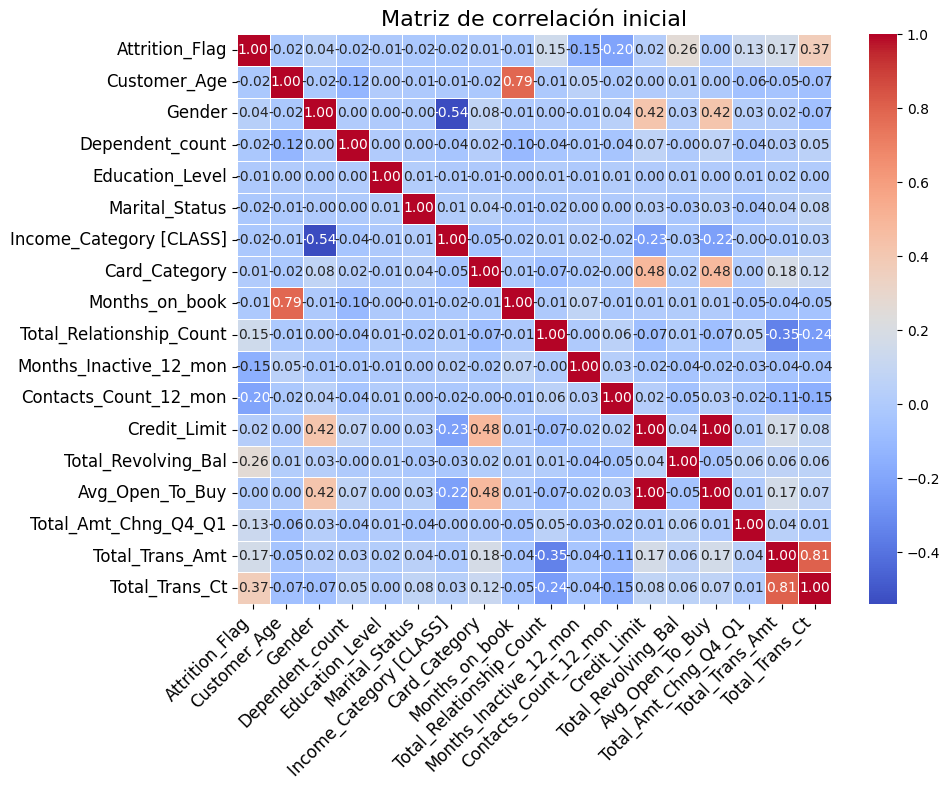

In [167]:
# Como ya sabemos nuestra variable a predecir, le añadimos en su nombre: [CLASE]
datos.rename(columns={'Income_Category': 'Income_Category [CLASS]'}, inplace=True)

# Eliminamos el nº de cliente ya que no ayuda a predecir nada
# Solo serviría de identificador para la fila, pero contamos con el nº de fila ya
datos_limpios = datos.drop(columns = ['CLIENTNUM'])
# Ya que vamos a predecir los ingresos, las predicciones ya existentes no nos sirven
datos_limpios = datos_limpios.drop(datos_limpios.columns[-2:], axis = 1)
# Con 'total transaction amount' y 'total transaction count', no vemos necesario el uso de las que ahora son las dos últimas columnas
# Para relacionar ingresos con gastos asociados a sus tarjetas nos sirve así
datos_limpios = datos_limpios.drop(datos_limpios.columns[-2:], axis = 1) 

# Calculamos la matriz de correlación (one-hot encoding)
#columnas_categoricas = ['Attrition_Flag', 'Education_Level', 'Marital_Status', 'Card_Category', 'Income_Category [CLASE]', 'Gender']
#datos_limpios_dummies = pd.get_dummies(datos_limpios, columns = columnas_categoricas)
#print(datos_limpios_dummies)
#matriz_correlacion = datos_limpios_dummies.corr()

# Identificar columnas categóricas
columnas_categoricas = ['Attrition_Flag', 'Education_Level', 'Marital_Status', 'Card_Category', 'Income_Category [CLASS]', 'Gender']
# Crear una copia del df para no modificar el original
datos_limpios_numericos = datos_limpios.copy()
# Aplicar Label Encoding a las columnas categóricas
label_encoders = {}
for col in columnas_categoricas:
    le = LabelEncoder()
    datos_limpios_numericos[col] = le.fit_transform(datos_limpios[col])
    label_encoders[col] = le  # Guardar el encoder si necesitas revertirlo luego

# Calcular la matriz de correlación
matriz_correlacion_inicial = datos_limpios_numericos.corr()

# Visualización del mapa de calor de correlaciones
plt.figure(figsize=(10, 8))  # Ajustar el tamaño del gráfico
sns.heatmap(
    matriz_correlacion_inicial, 
    annot = True,  # Mostrar valores numéricos
    fmt = ".2f",  # Mostramos 2 deccimales
    cmap = "coolwarm",
    linewidths = 0.5,
    annot_kws = {"size": 10} 
)

# Cambiamos labels y estética un poco
plt.title("Matriz de correlación inicial", fontsize=16)
plt.xticks(rotation=45, fontsize=12, ha="right")
plt.yticks(fontsize=12)
plt.tight_layout()  # Ajustar el diseño para evitar solapamiento
plt.show()


Hay que entender que, usando Naive-Bayes, se asume independencia entre las variables, así que, lo que parece una mala matriz de correlación en un principio, nos puede ser muy beneficiosa para el contexto de Naive-Bayes. 

Sabiendo eso, la matriz de correlación también nos sirve para descubir que 'credit_limit' y 'avg_open_to_buy' tienen una correlación perfecta. Esto significa que ya tenemos toda la información que nos aporta una de las variables, solo con la otra. Por ello quitamos 'avg_open_to_buy', que es la que nos parece menos descriptiva de las dos.


## 3. Preparación del dataset
Aquí realizaremos un preprocesado completo de nuestros datos para "prepararlos" para que sirvan para entrenar nuestro modelo. Hay que tener en cuenta que nuestro modelo será de clasificación y, en base a esto, realizar los cambios pertinentes en nuestro data frame.

Las columnas 'total trans amt' y 'total trans ct', una representa la cantidad de transferencias realizadas y la otra la cantidad de dinero total. Obviamente resultan las dos en una alta correlación (0,81) y, como creemos que la cantidad gastada total es más indicativa que el número de transferencias per se, quitamos 'total trans ct'. Para nuestra predicción de renta, no debería ser relevante los meses que lleva en x banco un usuario, por lo tanto, 'months on book', 'months inactive' y  'contacts count' las eliminamos también. Por último, 'total amt chng Q4 Q1' representa el cambio en la cantidad de transacciones que, de nuevo, creemos información ya incluida en otras variables ya incorporadas. También lo eliminamos. (Otra correlación algo desracable es la de 0,48 pero, como ya nos hemos quitado una de las variables implicadas, 'avg open to buy', ese "problema" se va a su vez).

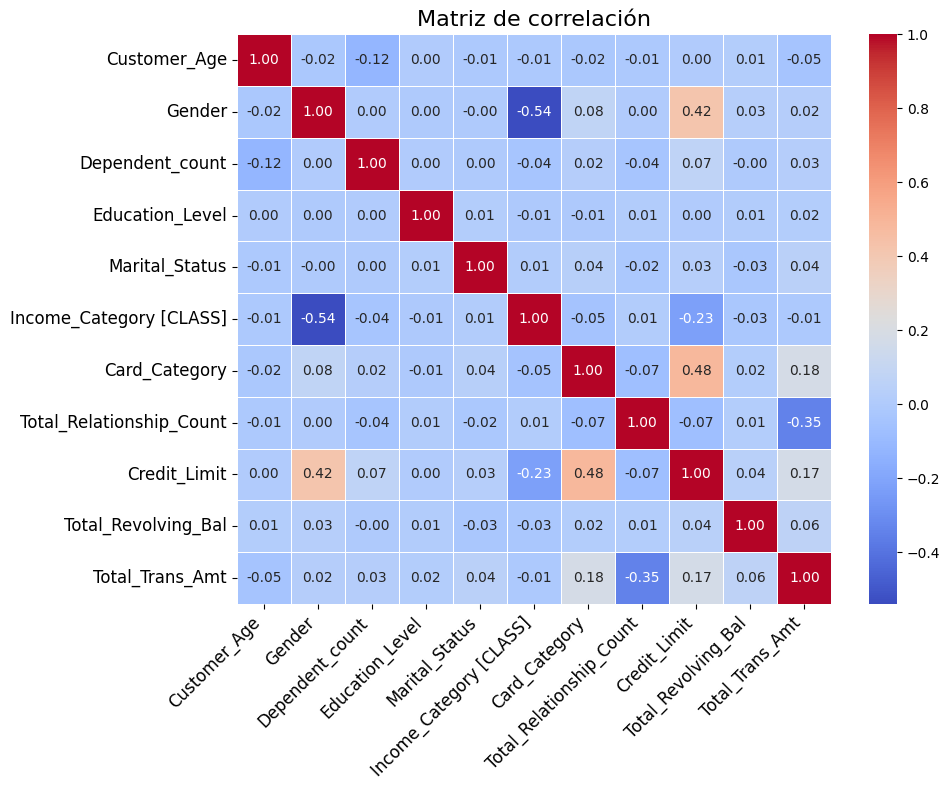

In [168]:
## Justificar debidamente estos .drop()
datos_limpios = datos_limpios.drop(columns = ['Avg_Open_To_Buy'])
datos_limpios = datos_limpios.drop(columns = ['Months_on_book'])
datos_limpios = datos_limpios.drop(columns = ['Months_Inactive_12_mon'])
datos_limpios = datos_limpios.drop(columns = ['Contacts_Count_12_mon'])
datos_limpios = datos_limpios.drop(columns = ['Total_Trans_Ct'])
datos_limpios = datos_limpios.drop(columns = ['Total_Amt_Chng_Q4_Q1'])
datos_limpios = datos_limpios.drop(columns = ['Attrition_Flag'])

# Volvemos a calcular la matriz de correlación igual que antes, ahora con el df que usaremos finalmente
datos_limpios_numericos = datos_limpios.copy()
columnas_categoricas.remove('Attrition_Flag')

label_encoders = {}
for col in columnas_categoricas:
    le = LabelEncoder()
    datos_limpios_numericos[col] = le.fit_transform(datos_limpios[col])
    label_encoders[col] = le

matriz_correlacion = datos_limpios_numericos.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(
    matriz_correlacion, 
    annot = True,
    fmt = ".2f", 
    cmap = "coolwarm",
    linewidths = 0.5,
    annot_kws = {"size": 10} 
)
plt.title("Matriz de correlación", fontsize=16)
plt.xticks(rotation=45, fontsize=12, ha="right")
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

Ahora simplemente ajustamos datos dentro de nuestro data frame que puedan no estar óptimos (como un N/A, por ejemplo).

In [169]:
print('Los rangos de ingresos son: ', datos_limpios['Income_Category [CLASS]'].unique())
# Vemos que hay valores Unkown, por lo que pasamos a reemplazarlos (imputarlos) por la moda de los datos, la calculamos
values, counts = np.unique(datos_limpios['Income_Category [CLASS]'], return_counts=True)
mode = values[np.argmax(counts)]

print(f"La moda del income es: {mode}")
# La moda de Income es 'menos de 40k', vamos a hacer una visualizacion rápida para ver si los datos de 'unkown
# Income' coinciden con los de 'less than 40k', para ello usaremos la moda de su género y la moda de sus 
# estudios, en caso de que concuerden los sustituiremos ('Unkown' -> 'Less than 40k')
moda_unk_gen = datos_limpios[datos_limpios['Income_Category [CLASS]'] == 'Unknown']['Gender'].mode()
moda_unk_est = datos_limpios[datos_limpios['Income_Category [CLASS]'] == 'Unknown']['Education_Level'].mode()

print('La moda de genero con unkown income es: ' , moda_unk_gen)
print('La moda de estudios con unkown income es: ', moda_unk_est)
# Vemos que la moda, es decir la mayoría de gente en 'unknown', son mujeres y que la mayoria son 'graduate',
# Por lo tanto, susitituimos los valores de 'unknown', por los valores de moda de las mujeres que sean a su vez 'graduate'.
moda_fem_grad = datos_limpios[(datos_limpios['Gender'] == "F") & (datos_limpios['Education_Level'] == 'Graduate')]['Income_Category [CLASS]'].mode()

print('La moda de Income de mujeres graduate es de: ', moda_fem_grad)
# Vemos que la moda de 'Income' de Mujeres 'Graduate' es también de 'Less than 40k' por lo que sustituimos los 
# valores 'unknown' por 'Less than 40k'
datos_limpios['Income_Category [CLASS]'] = datos_limpios['Income_Category [CLASS]'].replace('Unknown', 'Less than $40K')
# Comprobamos el cambio
print('Los nuevos datos unicos son: ', datos_limpios['Income_Category [CLASS]'].unique())

# Ahora hacemos lo mismo con 'Education_Level'
print('Los datos unicos de Educacion son: ', datos_limpios['Education_Level'].unique())
print('La moda de Education_Levele es:', datos_limpios['Education_Level'].mode())
# Cambiamos 'unknown' por su moda de dato, que es 'Graduate'
datos_limpios['Education_Level'] = datos_limpios['Education_Level'].replace('Unknown', 'Graduate')

print("\nAsí queda nuestro data frame ya limpio:")
datos_limpios

Los rangos de ingresos son:  ['$60K - $80K' 'Less than $40K' '$80K - $120K' '$40K - $60K' '$120K +'
 'Unknown']
La moda del income es: Less than $40K
La moda de genero con unkown income es:  0    F
Name: Gender, dtype: object
La moda de estudios con unkown income es:  0    Graduate
Name: Education_Level, dtype: object
La moda de Income de mujeres graduate es de:  0    Less than $40K
Name: Income_Category [CLASS], dtype: object
Los nuevos datos unicos son:  ['$60K - $80K' 'Less than $40K' '$80K - $120K' '$40K - $60K' '$120K +']
Los datos unicos de Educacion son:  ['High School' 'Graduate' 'Uneducated' 'Unknown' 'College' 'Post-Graduate'
 'Doctorate']
La moda de Education_Levele es: 0    Graduate
Name: Education_Level, dtype: object

Así queda nuestro data frame ya limpio:


,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category [CLASS],Card_Category,Total_Relationship_Count,Credit_Limit,Total_Revolving_Bal,Total_Trans_Amt
0,45,M,3,High School,Married,$60K - $80K,Blue,5,12691.0,777,1144
1,49,F,5,Graduate,Single,Less than $40K,Blue,6,8256.0,864,1291
2,51,M,3,Graduate,Married,$80K - $120K,Blue,4,3418.0,0,1887
3,40,F,4,High School,Unknown,Less than $40K,Blue,3,3313.0,2517,1171
4,40,M,3,Uneducated,Married,$60K - $80K,Blue,5,4716.0,0,816
...,...,...,...,...,...,...,...,...,...,...,...
10122,50,M,2,Graduate,Single,$40K - $60K,Blue,3,4003.0,1851,15476
10123,41,M,2,Graduate,Divorced,$40K - $60K,Blue,4,4277.0,2186,8764
10124,44,F,1,High School,Married,Less than $40K,Blue,5,5409.0,0,10291
10125,30,M,2,Graduate,Unknown,$40K - $60K,Blue,4,5281.0,0,8395


## 4. Implementación del algoritmo
Lo primero, antes de crear nuestro modelo, es ajustar distribuciones de nuestros atributos numéricos. Ya que es posible que no sigan de manera fiel a una distribución normal y, más tarde, usaremos esta misma como supuesto para nuestro algoritmo de Naive Bayes.

In [170]:
### Encuentra la distr. que mejor se ajusta a los datos numéricos
### de una columna dada
def encontrar_mejor_distribucion(datos, columna, distribuciones):
    """
    Encuentra la mejor distribución que ajusta los datos en una columna específica.

    Parámetros:
    - datos (pd.DataFrame): El DataFrame que contiene los datos.
    - columna (str): El nombre de la columna en el DataFrame a analizar.
    - distribuciones (list): Lista de distribuciones de scipy.stats a probar.

    Retorna:
    - dict: Un diccionario con la mejor distribución, parámetros y SSE.
    """
    # Validar entrada
    if columna not in datos.columns:
        raise ValueError(f"La columna '{columna}' no existe en el DataFrame.")

    if datos[columna].isnull().any():
        raise ValueError(f"La columna '{columna}' contiene valores nulos. Por favor, límpialos antes de continuar.")

    # Inicialización de variables
    best_fit = None
    best_params = None
    best_sse = np.inf

    # Datos a ajustar
    valores = datos[columna]
    x = np.linspace(valores.min(), valores.max(), 100)

    for dist in distribuciones:
        try:
            # Ajustar la distribución a los datos
            params = dist.fit(valores)

            # Generar datos ajustados
            pdf = dist.pdf(x, *params)

            # Calcular SSE
            sse = np.sum((valores.mean() - pdf) ** 2)

            # Actualizar mejor ajuste
            if sse < best_sse:
                best_sse = sse
                best_fit = dist
                best_params = params

        except Exception as e:
            print(f"Error ajustando la distribución {dist.name}: {e}")
            continue

    return {
        "mejor_distribucion": best_fit.name if best_fit else None,
        "parametros": best_params,
        "sse": best_sse
    }

### Encuentra la mejor distribución para cada columna especificada de un data frame dado
### (para atributos numéricos, claro)
def encontrar_mejores_distribuciones(datos, columnas, distribuciones):
    resultados = {}

    for columna in columnas:
        try:
            # Verificar que la columna exista
            if columna not in datos.columns:
                raise ValueError(f"La columna '{columna}' no existe en el DataFrame.")

            # Verificar que la columna no tenga valores nulos
            if datos[columna].isnull().any():
                raise ValueError(f"La columna '{columna}' contiene valores nulos.")

            # Encontrar la mejor distribución para esta columna
            resultado = encontrar_mejor_distribucion(datos, columna, distribuciones)
            resultados[columna] = resultado
        except Exception as e:
            # Capturar errores para columnas problemáticas
            resultados[columna] = {"error": str(e)}
            print(f"Error procesando la columna '{columna}': {e}")

    return resultados

# Con nuesras columnas numéricas
columnas_a_analizar = ['Credit_Limit', 'Customer_Age', 'Dependent_count', 'Credit_Limit', 
                       'Total_Revolving_Bal', 'Total_Trans_Amt', 'Total_Relationship_Count']
distribuciones = [stats.norm, stats.expon, stats.lognorm, stats.gamma]

# Procesar múltiples columnas
resultados_distribuciones = encontrar_mejores_distribuciones(datos_limpios, columnas_a_analizar, distribuciones)

for columna, info in resultados_distribuciones.items():
    print(f"\nColumna: {columna}")
    if "error" in info:
        print(f"Error: {info['error']}")
    else:
        print(f"Mejor distribución: {info['mejor_distribucion']}")
        print(f"Parámetros: {info['parametros']}")
        print(f"SSE: {info['sse']}")


c:\Users\Pablo (uni)\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6626: RuntimeWarning: overflow encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)
c:\Users\Pablo (uni)\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\_core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
c:\Users\Pablo (uni)\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_distn_infrastructure.py:2036: RuntimeWarning: overflow encountered in divide
  place(output, cond, self._pdf(*goodargs) / scale)



Columna: Credit_Limit
Mejor distribución: gamma
Parámetros: (np.float64(0.7110583545565183), np.float64(1438.2999999999997), np.float64(10070.058791708976))
SSE: 7450976063.532405

Columna: Customer_Age
Mejor distribución: gamma
Parámetros: (np.float64(4326.397499633611), np.float64(-481.4991848978759), np.float64(0.1219998519253355))
SSE: 214415.39948906982

Columna: Dependent_count
Mejor distribución: gamma
Parámetros: (np.float64(10054.35877545198), np.float64(-127.92210906569821), np.float64(0.012956414344567672))
SSE: 466.79652303274213

Columna: Total_Revolving_Bal
Mejor distribución: expon
Parámetros: (0.0, 1162.8140614199665)
SSE: 135213572.05368498

Columna: Total_Trans_Amt
Mejor distribución: expon
Parámetros: (510.0, 3894.086303939963)
SSE: 1939597568.069331

Columna: Total_Relationship_Count
Mejor distribución: norm
Parámetros: (np.float64(3.8125802310654686), np.float64(1.5543311177215595))
SSE: 1322.8865119488469


In [171]:
# Diccionario con las distribuciones ya ajustadas "manualmente"
distribuciones = {
    'Credit_Limit': (stats.gamma, (0.711, 0, 1438.30)),
    'Customer_Age': (stats.gamma, (4326.40, -481.50, 0.12)),
    'Dependent_count': (stats.gamma, (10054.36, -127.92, 0.01)),
    'Total_Revolving_Bal': (stats.expon, (0.0, 1162.81)),
    'Total_Trans_Amt': (stats.expon, (510.0, 3894.09)),
    'Total_Relationship_Count': (stats.norm, (3.8125, 1.5543))
}

Dividimos nuestros datos entre datos de entrenamiento y de test. Como nuestros datos no están ordenados cronológicamente (ni de otra forma tampoco), podemos dividir de forma "manual" el data frame.

In [172]:
num_filas = len(datos_limpios)
print(num_filas)

10127


Tenemos 10.127 filas, y dividiendo en un 80-20 los datos, nos quedan para entrenamiento 8.101,6 datos que, redondeando, dejaremos en 8.100. El resto serán para test.

In [173]:
datos_limpios_train = datos_limpios.iloc[:8100]
datos_limpios_test = datos_limpios.iloc[8100:]

In [174]:
### Devuelve las probabilidades condicionadas de nuestro data frame
### Para entrenar el modelo, simplemente le pasamos el data frame de entrenamiento y más tarde
### usaremos esos datos predichos de probabilidades para asignar a los de test y así predecir
### datos desconocidos también
def entrenar_naive_bayes(datos, clase, distribuciones_personalizadas=None):
    total_registros = len(datos)
    clases = datos[clase].unique()
    
    # Probabilidades de la clase ('icome_category')
    prob_clase = {cls: len(datos[datos[clase] == cls]) / total_registros for cls in clases}

    # Calculamos las probabilidades condicionales P(X|C) para cada atributo
    prob_condicionales = {}
    for col in datos.columns:
        if col == clase:  # Ignorar la clase
            continue
        if datos[col].dtype == 'object':  # Si el atributo es categórico
            prob_condicionales[col] = {}
            for cls in clases:
                prob_condicionales[col][cls] = datos[datos[clase] == cls][col].value_counts(normalize=True).to_dict()
        else:  # Si es numérico
            prob_condicionales[col] = {}
            for cls in clases:
                if distribuciones_personalizadas and col in distribuciones_personalizadas:
                    prob_condicionales[col][cls] = distribuciones_personalizadas[col][1]
                else:
                    # Si no hay distribución personalizada, usa la distribución normal
                    media = datos[datos[clase] == cls][col].mean()
                    desviacion = datos[datos[clase] == cls][col].std()
                    prob_condicionales[col][cls] = (media, desviacion)
    
    return prob_clase, prob_condicionales

### Nos da predicciones para cada fila para unas probabilidades ya dadas (modelo entrenado)
def predecir_naive_bayes(datos, prob_clase, prob_condicionales, clase, distribuciones_personalizadas=None):
    predicciones = []
    
    for _, row in datos.iterrows():
        # Inicializar el diccionario que almacenará las probabilidades para cada clase
        probs_clase_given_x = {cls: np.log(prob_clase[cls]) for cls in prob_clase}  # Inicializar con log(P(C))

        # Calcular P(C) * P(X|C) para cada clase
        for cls in prob_clase:
            for col in datos.columns:
                if col == clase:  # No procesar la variable de clase
                    continue
                valor_atributo = row[col]
                
                # Si el atributo es categórico
                if isinstance(valor_atributo, str):
                    if valor_atributo in prob_condicionales[col][cls]:
                        probs_clase_given_x[cls] += np.log(prob_condicionales[col][cls].get(valor_atributo, 1e-10))  # Evitar log(0)
                    else:
                        probs_clase_given_x[cls] += np.log(1e-10)  # Si el valor no aparece, asignar una pequeña probabilidad
                else:
                    # Si el atributo es numérico, usar la distribución personalizada o la normal
                    if distribuciones_personalizadas and col in distribuciones_personalizadas:
                        dist, params = distribuciones_personalizadas[col]
                        # Usamos la distribución predefinida para ese atributo
                        probabilidad = dist.pdf(valor_atributo, *params)
                        probs_clase_given_x[cls] += np.log(probabilidad if probabilidad > 1e-10 else 1e-10)  # Evitar log(0)
                    else:
                        # Si no hay distribución personalizada, usar la distribución normal
                        media, desviacion = prob_condicionales[col][cls]
                        probabilidad = (1 / (desviacion * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((valor_atributo - media) ** 2) / (desviacion ** 2))
                        probs_clase_given_x[cls] += np.log(probabilidad if probabilidad > 1e-10 else 1e-10)

        # Seleccionar la clase con la mayor probabilidad
        predicciones.append(max(probs_clase_given_x, key=probs_clase_given_x.get))
    
    return predicciones

def evaluar_modelo(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")

## 5. Entrenamiento del modelo
Procedemos a entrenar y evaluar nuestro modelo :)

In [175]:
clase = 'Income_Category [CLASS]'
prob_clase, prob_condicionales = entrenar_naive_bayes(datos_limpios_train, clase) # No usamos el parámetro para distr. personalizadas ya que da algo peor...

# Hacer las predicciones en el conjunto de prueba
y_true = datos_limpios_test[clase].values
y_pred = predecir_naive_bayes(datos_limpios_test, prob_clase, prob_condicionales, clase) # No usamos el parámetro para distr. personalizadas ya que da algo peor...

## 6. Evaluación de nuestro modelo

In [176]:
evaluar_modelo(y_true, y_pred)

Accuracy: 0.5599
Precision: 0.5257
Recall: 0.5599
F1-Score: 0.5306


## 7. Comparación con el algoritmo de scikit-learn
Utilizo ahora scikit-learn para comprobar los resultados que obtiene su algoritmo, y ver si son los mismos que los míos.

In [177]:
# Codificar las columnas categóricas necesarias
label_encoder = LabelEncoder()
columns_to_encode = ['Education_Level', 'Marital_Status',
                     'Card_Category', 'Income_Category [CLASS]', 'Gender']
for col in columns_to_encode:
    datos_limpios[col] = label_encoder.fit_transform(datos_limpios[col])

# Separar variables predictoras (x) y variable objetivo (y)
var_predictoras = datos_limpios.drop(columns = ['Income_Category [CLASS]'])
var_objetivo = datos_limpios['Income_Category [CLASS]']

# Dividir el dataset en conjunto de entrenamiento y prueba
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(var_predictoras, var_objetivo, test_size = 0.3, random_state = 42)

# Entrenar el modelo Naive Bayes
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
y_pred = gnb.fit(X_train, y_train).predict(X_test)

# Evaluar el modelo
from sklearn.metrics import accuracy_score, classification_report
print(f"Accuracy del modelo: {accuracy_score(y_test, y_pred):.4f}")
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred))

Accuracy del modelo: 0.5798

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.26      0.15      0.19       220
           1       0.22      0.22      0.22       513
           2       0.35      0.37      0.36       417
           3       0.42      0.35      0.39       455
           4       0.82      0.91      0.86      1434

    accuracy                           0.58      3039
   macro avg       0.42      0.40      0.40      3039
weighted avg       0.56      0.58      0.57      3039



### Observaciones de los resultados:
**Dominancia de una clase:**
- La clase Less than $40K tiene una gran proporción de ejemplos (1434 de 3039, casi el 47%).
- El modelo tiende a predecir esta clase correctamente, lo que eleva el accuracy global, pero reduce el rendimiento en las demás clases.

**Clases con menos ejemplos:**

Clases como $120K + y $40K - $60K tienen un rendimiento significativamente menor debido a su bajo soporte (número de ejemplos).

**Macro vs Weighted Avg:**
- El promedio macro da un peso igual a cada clase y refleja un f1-score bajo (0.38), lo que indica problemas con las clases minoritarias.
- El promedio ponderado refleja mejor el balance global, pero está sesgado hacia la clase mayoritaria.

In [178]:
# Aplicar SMOTE para equilibrar las clases
smote = SMOTE(random_state = 42) # Fijamos semilla para reproducibilidad
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Entrenar el modelo con los datos equilibrados
gnb = GaussianNB()
y_pred_resampled = gnb.fit(X_resampled, y_resampled).predict(X_test)

# Evaluar el modelo nuevamente
print(f"Accuracy del modelo con SMOTE: {accuracy_score(y_test, y_pred_resampled):.4f}")
print("\nReporte de clasificación con SMOTE:")
print(classification_report(y_test, y_pred_resampled))

Accuracy del modelo con SMOTE: 0.5252

Reporte de clasificación con SMOTE:
              precision    recall  f1-score   support

           0       0.31      0.35      0.33       220
           1       0.19      0.15      0.17       513
           2       0.34      0.63      0.44       417
           3       0.37      0.24      0.29       455
           4       0.82      0.75      0.78      1434

    accuracy                           0.53      3039
   macro avg       0.40      0.42      0.40      3039
weighted avg       0.54      0.53      0.52      3039



Para equilibrar las clases hemos hecho uso de SMOTE.

- El uso de SMOTE ha equilibrado las clases, pero el accuracy general ha disminuido,
- lo que es esperable porque ahora el modelo está menos sesgado hacia la clase mayoritaria (Less than $40K).

### Análisis de los resultados con SMOTE:

**Impacto del equilibrio:**
- Las clases minoritarias ($120K +, $40K - $60K, etc.) muestran un mejor recall (p.ej., $120K + pasa de 0.30 a 0.40 y $40K - $60K de 0.33 a 0.42).
- Sin embargo, su precision y f1-score no mejoran significativamente, lo que indica que el modelo todavía lucha para diferenciar entre estas clases.

**Clase mayoritaria afectada:**
La clase Less than $40K tiene menor recall (0.88 → 0.66) debido al impacto del equilibrio en las predicciones del modelo.

**Accuracy general más bajo:**
Esto ocurre porque el modelo está siendo evaluado en un conjunto con una distribución diferente de la usada en entrenamiento, y su capacidad para capturar patrones específicos ha disminuido.

## 8. Conclusiones
Podemos observar que nuestro propio algoritmo de Naive Bayes da unos resultados muy similares a los que obtenemos si entrenamos con scikit-learn, lo que nos da a entender que nuestro algoritmo al menos con estas variables predictoras, no dista mucho de la solución arrojada por un modelo integrado en una libreria seria, haciendo que como poco, sea válido. 

Analizando más en profundidad los números, un accuracy (y demas métricas que resultan similares numéricamente) de ~0,5 no están mal teniendo en cuenta que hay 5 posibles clasificaciones de nuestra variable predicha(Income): 'lower 40k', '40k-60k', '60k-80k', '80k-120k', '120k+'. En caso de que fuese mediante elección aleatoria, la probabilidad de acertar es de 0,2, que es menos de la mitad que mediante nuestro algoritmo, en conclusión, si bien nuestro algoritmo no deberia ser tomado de forma seria para ningun tipo de estudio(debido a que falla bastantes veces, es una mejor forma que de haberlo hecho de forma aleatoria), es una forma de ver como se ajusta un dataset(en principio con variables independientes entre si) al modelo Naive Bayes y sus predicciones .